In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

import pylab
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
# параметры двумерного распределения
mu1 = [-2., -2.]
cov1 = [1., 1.]

mu2 = [3., -2.]
cov2 = [2., 2.]

In [3]:
def sample_vector(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [4]:
d0 = torch.distributions.MultivariateNormal(torch.tensor(mu1), torch.diag(torch.tensor(cov1)))
d1 = torch.distributions.MultivariateNormal(torch.tensor(mu2), torch.diag(torch.tensor(cov2)))

In [5]:
layer = nn.Linear(2, 1) # два признака + байес, один выход
print([p.data[0] for p in layer.parameters()]) # параметры модели до оптимизации
opt = optim.SGD(lr=1, params=list(layer.parameters()))

[tensor([-0.2129, -0.2966]), tensor(-0.3172)]


In [6]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample_vector(d0, d1, 100000)
            out = F.sigmoid(layer(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    x, y = sample_vector(d0, d1, 1024)
    out = F.sigmoid(layer(x))
    opt.zero_grad()
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    opt.step()

Ошибка после 0 итераций: 1.020237
Ошибка после 1 итераций: 0.052981
Ошибка после 2 итераций: 0.051279
Ошибка после 3 итераций: 0.051870
Ошибка после 4 итераций: 0.052236
Ошибка после 5 итераций: 0.051948
Ошибка после 6 итераций: 0.051967
Ошибка после 7 итераций: 0.051911
Ошибка после 8 итераций: 0.052548
Ошибка после 9 итераций: 0.053160
Ошибка после 10 итераций: 0.052243
Ошибка после 11 итераций: 0.051349
Ошибка после 12 итераций: 0.054173
Ошибка после 13 итераций: 0.052776
Ошибка после 14 итераций: 0.052437
Ошибка после 15 итераций: 0.051715
Ошибка после 16 итераций: 0.052124
Ошибка после 17 итераций: 0.051418
Ошибка после 18 итераций: 0.051359
Ошибка после 19 итераций: 0.051061


In [7]:
print([p.data[0] for p in layer.parameters()]) # параметры модели после оптимизации

[tensor([ 3.4690, -0.0254]), tensor(-0.4934)]


<Figure size 504x360 with 0 Axes>

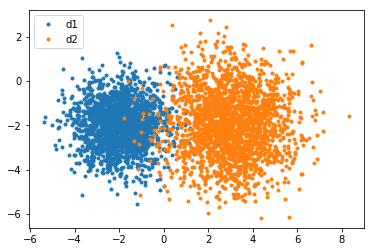

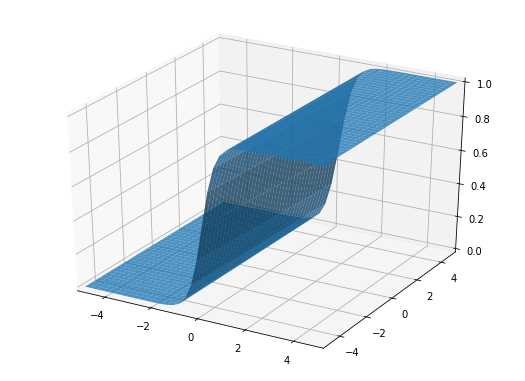

In [8]:
# Визуализация

# 1. Приорное распределение
zx1, zy1 = np.random.multivariate_normal(np.array(mu1), np.diag(cov1), 2000).T
zx2, zy2 = np.random.multivariate_normal(np.array(mu2), np.diag(cov2), 2000).T

plt.figure(figsize=(7, 5))

fig = plt.figure()
plt.plot(zx1, zy1, '.', label='d1')
plt.plot(zx2, zy2, '.', label='d2')
plt.legend()

# 2. Разделяющая поверхность
x, y = np.mgrid[-5.0:5.0:40j, -5.0:5.0:40j]
xy = np.column_stack([x.flat, y.flat])
xy_tensor = torch.tensor(xy, dtype=torch.float)

with torch.no_grad():
    z = F.sigmoid(layer(xy_tensor)).numpy()

z = z.reshape(x.shape)

fig = pylab.figure(figsize=(7,5))
axes = Axes3D(fig)

axes.set_xlim3d(-5, 5)
axes.set_ylim3d(-5, 5)
axes.set_zlim3d(-0, 1)

axes.plot_surface(x, y, z, alpha=0.8)

pylab.show()
